In [1]:
from fastai.vision.all import *
import fastai
import timm
import pandas as pd

In [2]:
import torch
torch.cuda.set_device(2)

In [3]:
df = pd.read_csv('../dataset.csv')

In [4]:
df = df.drop(df[df.masa<0].index)

In [5]:
dftrain = df[(df.split=='train') | (df.split=='valid')]
dftest = df[(df.split=='test')]

In [6]:
# !mkdir ../datasetAltura/train
# !mkdir ../datasetAltura/test

In [7]:
# import shutil
# from imutils import paths

In [8]:
# for image in dftrain.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetAltura'),
#                 image.replace('datasetClean','../datasetAltura/train'))

In [9]:
# for image in dftest.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetAltura'),
#                 image.replace('datasetClean','../datasetAltura/test'))

In [10]:
# df.volumen.describe()

In [11]:
def get_masa(f):
    f = f[0]
    return float(df[df['image_id']=='datasetClean/'+f.name]['masa'])

def get_volumen(f):
    f = f[0]
    return float(df[df['image_id']=='datasetClean/'+f.name]['volumen'])

def is_valid(f):
    f = f[0]
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='valid'

In [12]:
class ImageTuple(fastuple):
    @classmethod
    def create(cls, fns): 
        return cls(tuple(PILImage.create(f) for f in fns))
    
    def show(self, ctx=None, **kwargs): 
        t1,t2 = self
        if not isinstance(t1, Tensor) or not isinstance(t2, Tensor) or t1.shape != t2.shape: return ctx
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), ctx=ctx, **kwargs)

In [13]:
def ImageTupleBlock(): return TransformBlock(type_tfms=ImageTuple.create, batch_tfms=IntToFloatTensor)

In [14]:
def get_tuples(files):
    return [[f, Path(str(f).replace('datasetClean','datasetAltura2'))] for f in get_image_files(files)]

In [15]:
import albumentations

In [16]:
class MyTransform(Transform):
    def __init__(self): self.aug = albumentations.Compose([
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
            albumentations.VerticalFlip(p=0.5),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.CoarseDropout(p=0.5),
            albumentations.Cutout(p=0.5)
        ])
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [17]:
def getDataBlock(presize=224,size=224):
    return DataBlock(blocks = (ImageTupleBlock, RegressionBlock()),
                 get_items=get_tuples, 
                 splitter=FuncSplitter(is_valid),
                 get_y=get_masa,
                 item_tfms = [Resize(presize)],
                 batch_tfms=[MyTransform(),Normalize.from_stats(*imagenet_stats)])

In [18]:
path = Path('../datasetClean/')
trainPath = path/'train'

In [19]:
db = getDataBlock()
dls = db.dataloaders(trainPath,bs=64)

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:691: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


In [20]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnet50Masav2HeightOrtofoto')
]

In [21]:
from fastai.metrics import mae,rmse,mse

In [22]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    
    def forward(self, x):
        x1,x2=x
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)

In [23]:
encoder = create_body(resnet50, cut=-2)

In [24]:
head = create_head(4096, 1, ps=0.5)
model = SiameseModel(encoder, head)

In [25]:
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

In [26]:
learn = Learner(dls, model,splitter=siamese_splitter,
                loss_func=MSELossFlat(), metrics=[mae,rmse,mse],cbs=callbacks).to_fp16()

In [27]:
# learn.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,110887.414062,126308.039062,285.350037,355.398407,126308.039062,00:04


Better model found at epoch 0 with valid_loss value: 126308.0390625.


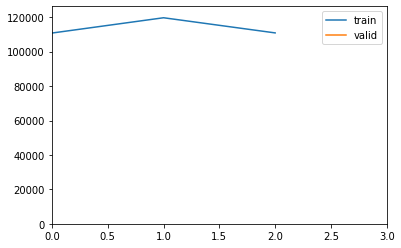

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,113270.023438,126277.476562,285.286835,355.355408,126277.476562,00:04
1,111338.421875,126279.914062,285.279449,355.358856,126279.914062,00:03
2,109828.289062,126284.609375,285.270935,355.365448,126284.609375,00:03
3,110437.531250,126292.710938,285.271729,355.376862,126292.710938,00:03
4,110456.671875,126969.835938,298.659576,356.328278,126969.835938,00:03
5,109593.250000,126479.539062,298.509918,355.639587,126479.539062,00:03
6,108299.046875,124921.070312,296.412933,353.441742,124921.070312,00:04
7,107086.320312,123366.375000,294.837250,351.235504,123366.375000,00:03
8,106243.835938,122052.273438,293.442841,349.359772,122052.273438,00:03
9,105010.343750,120707.757812,292.773895,347.430206,120707.757812,00:03


Better model found at epoch 0 with valid_loss value: 126277.4765625.


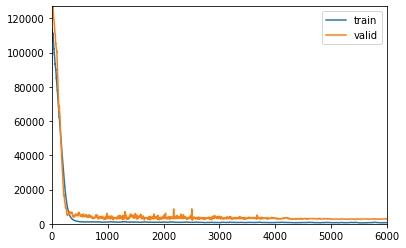

Better model found at epoch 6 with valid_loss value: 124921.0703125.
Better model found at epoch 7 with valid_loss value: 123366.375.
Better model found at epoch 8 with valid_loss value: 122052.2734375.
Better model found at epoch 9 with valid_loss value: 120707.7578125.
Better model found at epoch 10 with valid_loss value: 119621.328125.
Better model found at epoch 11 with valid_loss value: 118886.2578125.
Better model found at epoch 12 with valid_loss value: 118052.2734375.
Better model found at epoch 13 with valid_loss value: 116908.671875.
Better model found at epoch 14 with valid_loss value: 115634.1484375.
Better model found at epoch 15 with valid_loss value: 114082.5859375.
Better model found at epoch 16 with valid_loss value: 112273.546875.
Better model found at epoch 17 with valid_loss value: 111769.4296875.
Better model found at epoch 18 with valid_loss value: 110762.765625.
Better model found at epoch 19 with valid_loss value: 109637.7109375.
Better model found at epoch 20 w

In [28]:
learn.fine_tune(2000,base_lr=3e-2)

In [29]:
learn.load('resnet50Masav2HeightOrtofoto')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [30]:
def is_test(f):
    f = f[0]
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='test'

In [31]:
dbtest = DataBlock(blocks = (ImageTupleBlock, RegressionBlock()),
                 get_items=get_tuples, 
                 splitter=FuncSplitter(is_test),
                 get_y=get_masa,
                 item_tfms = [Resize(224)],
                 batch_tfms=[MyTransform(),Normalize.from_stats(*imagenet_stats)])

In [32]:
dlstest = dbtest.dataloaders(path,bs=16)

In [33]:
learn.dls=dlstest

In [34]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 45.94594192504883.


(#4) [5155.640625,45.94594192504883,71.80278778076172,5155.640625]

In [35]:
from sklearn.metrics import mean_absolute_error

In [36]:
preds,gt = learn.tta()

In [37]:
mean_absolute_error(gt,preds)

44.059986